### Answering Descriptive and Exploratory Questions About my Project

In [9]:
# Import packages
import igraph as ig
import numpy as np
import math
import os
from subprocess import Popen, PIPE

# Initializing dataset names
dnames = list(['../data/desikan/MRN114', '../data/desikan/KKI2009', '../data/desikan/SWU4'])
print "Datasets: " + ", ".join(dnames)
print "D = " + str(len(dnames))

# Getting graph names
fs = list()
for dd in dnames:
        fs.extend([root+'/'+file for root, dir, files in os.walk(dd) for file in files])
        
# fs

Datasets: ../data/desikan/MRN114, ../data/desikan/KKI2009, ../data/desikan/SWU4
D = 3


**Descriptive** <br />
- *What is N<sub>i</sub> for all i?*

In [10]:
# Get lengths of sublists and total list
print "N_i for each dataset (same order as above): " +\
      ", ".join([str(len(filter(lambda x: dd in x, fs))) for dd in dnames])
print "Total N = " + str(len(fs))

N_i for each dataset (same order as above): 114, 42, 454
Total N = 610


- *What is |V|?*

In [11]:
# We know that |V| is the same for all graphs, so here we really only need to load in 1
graph = ig.Graph.Read_GraphML(fs[0])
V = graph.vcount()
print "|V| = " + str(V)

|V| = 70


- *Do the graphs G<sub>n<sub>i</sub></sub> contain any values of A that cannot be processed traditionally (i.e. inf, NaN)?*

In [12]:
# We actually need the graphs in memory now, it seems. I'll make a janky function for this
# in case I want to do it again later for some reason.
def loadGraphs(filenames, rois, printer=False):
    A = np.zeros((rois, rois, len(filenames)))
    for idx, files in enumerate(filenames):
        if printer:
            print "Loading: " + files
        g = ig.Graph.Read_GraphML(files)
        tempg = g.get_adjacency(attribute='weight')
        A[:,:,idx] = np.asarray(tempg.data)
        
    return A

A = loadGraphs(fs, V)
        
# Parallel index for datasets
c = 0
d_idx = []
for dd in dnames:
    d_idx.append([c for root, dir, files in os.walk(dd) for file in files])
    c += 1
d_idx = np.concatenate(d_idx)

A.shape

(70, 70, 610)

In [13]:
# Now that my graphs are here, let's count NaNs and Infs in the set of them
nans= np.count_nonzero(np.isnan(A))
infs= np.count_nonzero(np.isinf(A))
print "Our data contains " + str(nans) + " NaN values"
print "Our data contains " + str(infs) + " Inf values"

Our data contains 0 NaN values
Our data contains 0 Inf values


- *How sparse, |E<sub>n<sub>i</sub></sub>| / |V<sub>n<sub>i</sub></sub>|x|V<sub>n<sub>i</sub></sub>|, are the graphs?*

In [14]:
# First I'll want to binarize my adjacency matrix, then I can do population
# sparsity by summing all edges and diving by total number of possible edges.
# Alternatively, I could've done this per graph and averaged, or per dataset
# and averaged. I chose this one because I did.
bin_graph = 1.0*(A > 0)
sparsity = np.sum(bin_graph) / (V*V*len(fs))
print "The fraction of possible edges that exist in our data is: " + str(sparsity)

The fraction of possible edges that exist in our data is: 0.561401806624


**Exploratory** <br />
- *What is mean(|E|) for each dataset i?*

In [15]:
# This was computed across all graphs for each data set

bin_graph = 1.0*(A > 0)

for idx in np.unique(d_idx):
    print 'Mean edge degree for dataset: ' + dnames[idx] + ' is: ' + \
    str(np.sum((bin_graph[:,:,d_idx == idx]))/np.sum(d_idx == idx))

Mean edge degree for dataset: ../data/desikan/MRN114 is: 2862.24561404
Mean edge degree for dataset: ../data/desikan/KKI2009 is: 1396.71428571
Mean edge degree for dataset: ../data/desikan/SWU4 is: 2848.17621145


- *What is the average graph, where average here means the graph consiting of edges and weights corresponding to the average weight of a given potential edge across the all the datasets?*

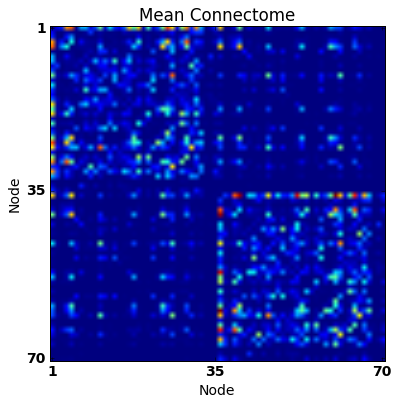

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

A_bar = (np.mean(A,axis=2))
plt.figure(figsize=(6, 6))
plt.imshow(A_bar)
plt.xticks((0, 34, 69), ('1', '35', '70'))
plt.yticks((0, 34, 69), ('1', '35', '70'))
plt.xlabel('Node')
plt.ylabel('Node')
plt.title('Mean Connectome')
plt.savefig('../figs/mean_connectome.png')
plt.show()


- *What is the distribution of max(A)-min(A) (i.e. dynamic range) for each dataset i?*

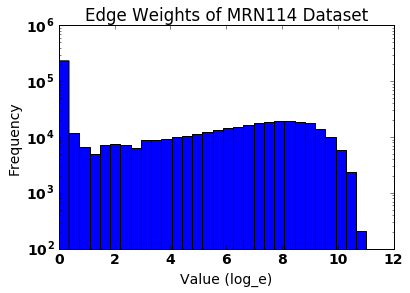

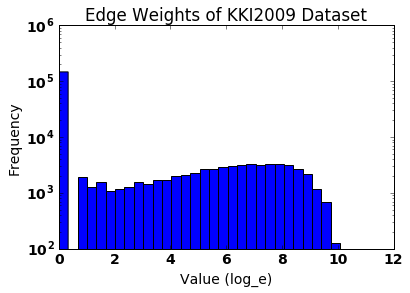

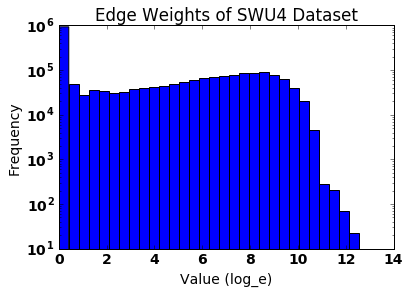

In [40]:
# first find min(A), max(A) for all data

for idx in np.unique(d_idx):
    A_ds = A[:,:,d_idx == idx]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(np.log(np.ravel(A_ds)+1), bins=30) #adding 1 to prevent divide by 0
    plt.title('Edge Weights of ' + dnames[idx].split('/')[-1] + ' Dataset')
    plt.xlabel("Value (log_e)")
    plt.ylabel("Frequency")
    ax.set_yscale('log')
    plt.savefig('../figs/'+dnames[idx].split('/')[-1]+'_ew_initial.png')
    plt.show()
